In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.layers import TextVectorization
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from keras.applications.vgg16 import VGG16
from tqdm.notebook import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

0it [00:00, ?it/s]

In [2]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
# extract features from image
features = {}
directory = os.path.join("C:\\Users\\will\\Desktop\\archive", 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    
# store features in pickle
dump(features, open('features.pkl', 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
features = load(open('features.pkl', 'rb'))


In [5]:
#load document and put contents in to a string 
def load_fp(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#creates dictionary to pair images to all 5 captions in database
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split("\n")
    descriptions = {}
    for capt in captions[:-1]:
        img, capt = capt.split("\t")
        if(img[:-2] not in descriptions):
            descriptions[img[:-2]] = [capt]
        else:
            descriptions[img[:-2]].append(capt)
            
    return descriptions

#data cleaning function to turn uppercase into lowercase and puncuation removal
def text_cleaning(text):
    punct = str.maketrans('','',string.punctuation)
    for img, capt in text.items():
        for i,img_capt in enumerate(capt):
            img_capt.replace("-"," ")
            desc = img_capt.split()
            desc = [wrd.lower() for wrd in desc]
            desc = [wrd.translate(punct) for wrd in desc]
            desc = [wrd for wrd in desc if(len(wrd)>1)]
            desc = [wrd for wrd in desc if(wrd.isalpha())]
            img_capt = ' '.join(desc)
            img_capt = 'startcaption ' + img_capt  + ' endcaption'
            text[img][i] = img_capt
    return text
    
#create list of all unique words in descriptions
def vocab(desc):
    vocab = set()
    for key in desc.keys():
        [vocab.update(d.split()) for d in desc[key]]
    return vocab

#save all descriptions in one file
def save_description(descriptions,filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
           lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    


In [6]:
with open(os.path.join('C:\\Users\\will\\Desktop\\archive', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
#dataset_text = "C:captionProject - Image Caption GeneratorFlicker8k_text"
#dataset_image = "C:captionProject - Image Caption GeneratorFlicker8k_Dataset"

dataset_text = "C:\captionProject\Flickr8k_text"
dataset_images = "C:\captionProject\Flickr8k_Dataset\Flicker8k_Dataset"

fileName = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = img_capt(fileName)

#f = open("capt_test.txt","w+")
#f.write(str(descriptions))

print("Length of descriptions, ",len(descriptions))

cleaned_captions = text_cleaning(descriptions)
        
vocabulary = vocab(cleaned_captions)

text_cleaning(mapping)

print("Length of vocabulary list, ",len(vocabulary))

save_description(cleaned_captions, "descriptions.txt")

print("done")

Length of descriptions,  8092
Length of vocabulary list,  8765
done


In [12]:
mapping['1000268201_693b08cb0e']

['startcaption child in pink dress is climbing up set of stairs in an entry way endcaption',
 'startcaption girl going into wooden building endcaption',
 'startcaption little girl climbing into wooden playhouse endcaption',
 'startcaption little girl climbing the stairs to her playhouse endcaption',
 'startcaption little girl in pink dress going into wooden cabin endcaption']

In [9]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [10]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['startcaption child in pink dress is climbing up set of stairs in an entry way endcaption',
 'startcaption girl going into wooden building endcaption',
 'startcaption little girl climbing into wooden playhouse endcaption',
 'startcaption little girl climbing the stairs to her playhouse endcaption',
 'startcaption little girl in pink dress going into wooden cabin endcaption',
 'startcaption black dog and spotted dog are fighting endcaption',
 'startcaption black dog and tricolored dog playing with each other on the road endcaption',
 'startcaption black dog and white dog with brown spots are staring at each other in the street endcaption',
 'startcaption two dogs of different breeds looking at each other on the road endcaption',
 'startcaption two dogs on pavement moving toward each other endcaption']

In [11]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

8766

In [12]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [13]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)
test = image_ids[:split]
train = image_ids[split:]

In [14]:
# create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [15]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')



In [28]:
# train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
model.save('saved_model/realModel2' + ".h5")

25/25 [==============================] - 46s 2s/step - loss: 0.6622


In [29]:
model.save('saved_model/model' + ".h5")

In [16]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, photo,tokenizer, max_length):
    in_text = 'startcaption'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endcaption':
            break
    return in_text



In [35]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/7281 [00:00<?, ?it/s]

BLEU-1: 0.480876
BLEU-2: 0.244512


In [18]:
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("C:\\Users\\will\\desktop\\archive\\images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("REAL CAPTIONS------")
    for caption in captions:
        print(caption)
    print("PREDICTED CAPTIONS-------")
    y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)
    

In [17]:
import tensorflow as tf
model = tf.keras.models.load_model('saved_model/realModel2.h5')

REAL CAPTIONS------
startcaption backpacker in the mountains using his hiking stick to point at glacier endcaption
startcaption backpacker points to the snowcapped mountains as he stands on rocky plain endcaption
startcaption hiker is pointing towards the mountains endcaption
startcaption hiker poses for picture in front of stunning mountains and clouds endcaption
startcaption man with green pack using his pole to point to snowcapped mountains endcaption
PREDICTED CAPTIONS-------
startcaption backpacker points to the snowcapped mountains as he stands on rocky plain endcaption


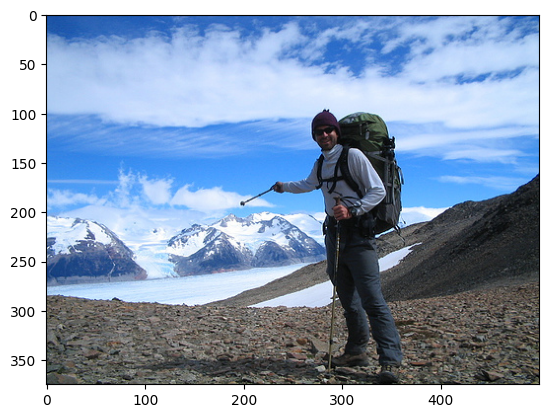

In [19]:
generate_caption("54501196_a9ac9d66f2.jpg")

REAL CAPTIONS------
startcaption brown dog running in yard endcaption
startcaption dog runs on the grass in yard gazebo in the background endcaption
startcaption dog trotting through someone yard endcaption
startcaption large brown dog is running through grassy backyard endcaption
startcaption large brown dog runs through large grassy area endcaption
PREDICTED CAPTIONS-------
startcaption dog jumps over chain endcaption


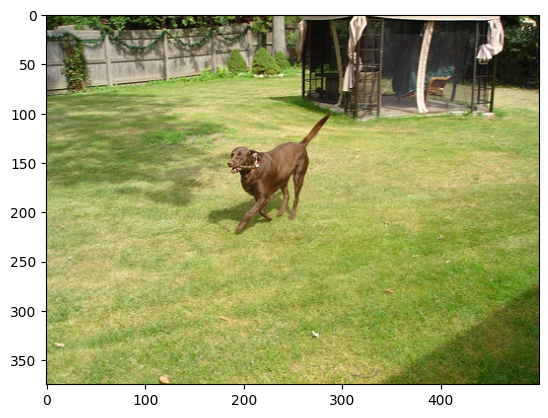

In [20]:
generate_caption("207275121_ee4dfa0bf2.jpg")

REAL CAPTIONS------
startcaption lone climber on snowcapped mountain with several huge mountains in the background endcaption
startcaption man is standing looking at the path ahead while hiking in mountain range endcaption
startcaption man on top of mountain looks at the mountains surrounding him endcaption
startcaption person with backpack stands on snowy mountain endcaption
startcaption sole mountain climber stands atop snowy peak looking left endcaption
PREDICTED CAPTIONS-------
startcaption man is standing looking at the path ahead while hiking in mountains endcaption


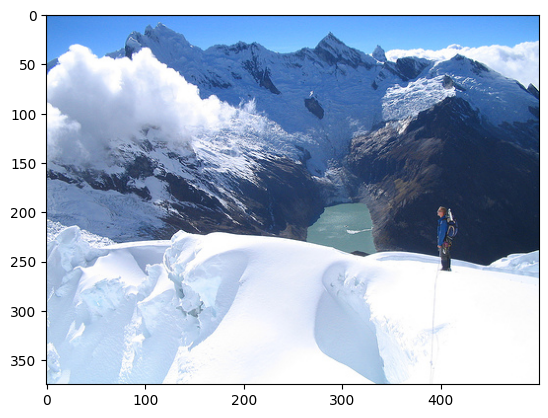

In [21]:
generate_caption("56494233_1824005879.jpg")

REAL CAPTIONS------
startcaption brown dog is running through brown field endcaption
startcaption brown dog is running through the field endcaption
startcaption brown dog with collar runs in the dead grass with his tongue hanging out to the side endcaption
startcaption brown dog with his tongue wagging as he runs through field endcaption
startcaption dog running in the grass endcaption
PREDICTED CAPTIONS-------
startcaption dog running through field endcaption


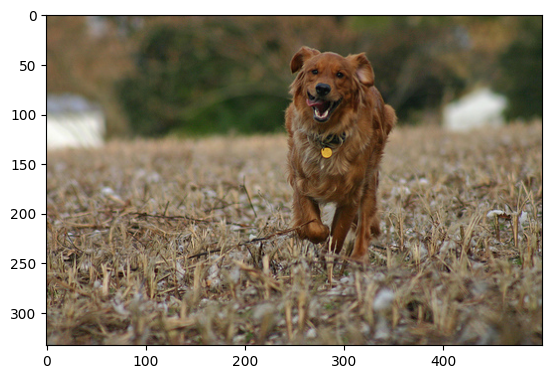

In [22]:
generate_caption("69189650_6687da7280.jpg")